In [1]:
import sys
sys.path.insert(0, './../')

import os
import utils_modelling as utils

In [2]:
path_dataset = "./../../../dataset_used_split_aug"
path_test = os.path.join(path_dataset, "test")
test_img, test_mask = utils.load_img_mask(path_test)
testset = utils.create_dataset(test_img, test_mask)

In [3]:
predicted_mask, model = utils.predict_model(testset, file_name="unet_model_aug", batches=8, get_one=False)


1/1 [==============================] - 0s 185ms/step


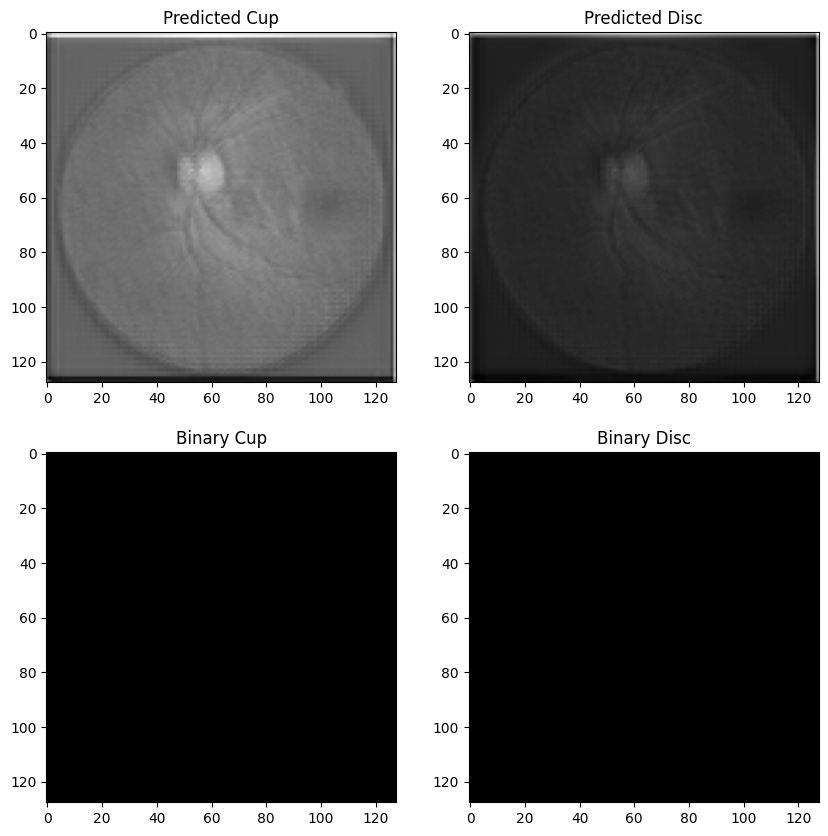

In [4]:
cup_mask, disc_mask, bcup_mask, bdisc_mask = utils.split_disc_cup_mask(predicted_mask[0], treshold=.2, img_idx=0)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Mask shape:  (128, 128, 3)
[0 1]


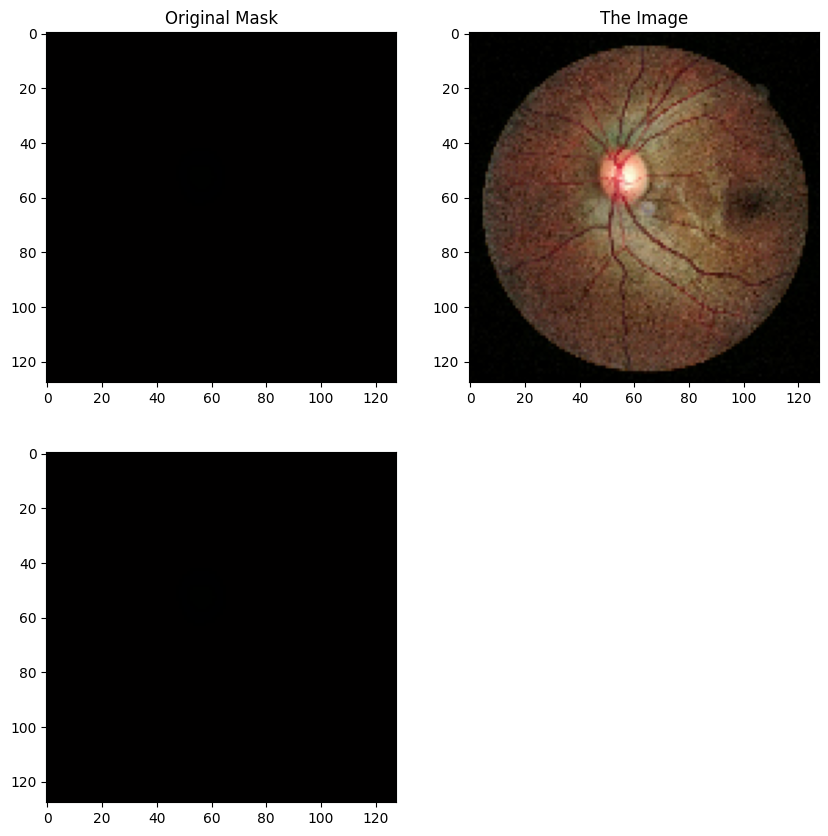

In [9]:
for image, mask in testset.take(1):
    update_mask = tf.where(mask == 2, 0, mask)
    # update_mask = tf.where(mask == 2, 1, mask)
    
    idx=0
    print("Mask shape: ", mask[idx].shape)
    print(np.unique(mask[idx]))
    plt.figure(figsize=(10, 10))
    plt.subplot(2,2, 1)
    plt.imshow(mask[idx], cmap="gray")
    plt.title("Original Mask")
    plt.subplot(2,2, 2)
    plt.imshow(image[idx])
    plt.title("The Image")
    plt.subplot(2,2, 3)
    plt.imshow(update_mask[idx], cmap="gray")

(16, 128, 128, 3)


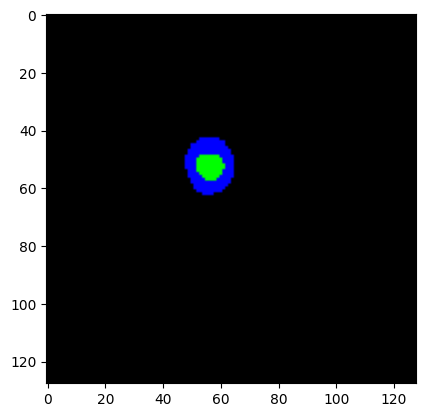

In [12]:
mask_indices = np.argmax(mask, axis=-1)
colormap = np.array([[0, 0, 0],       # background - black
                     [0, 255, 0],     # disc - green
                     [0, 0, 255]])    # cup - blue

# Step 3: Map the class indices to colors
mask_rgb = colormap[mask_indices]
print(mask_rgb.shape)
plt.imshow(mask_rgb[0])

In [10]:
print(f"binary cup mask: {bcup_mask.shape}",
      f"cup mask: {cup_mask.shape}",
      f"predicted_mask: {predicted_mask[0].shape}",
      f"mask: {mask[0].shape}",
      sep="\n")

binary cup mask: (16, 128, 128)
cup mask: (16, 128, 128)
predicted_mask: (16, 128, 128, 3)
mask: (128, 128, 3)


Metrics:
- IoU = tp / (tp +fp + fn)
- Dice Score
- Precision
- Recal